# Module 7: 特徵選擇 - 4. 降維 (Dimensionality Reduction)

## 學習目標
- 理解降維技術的基本概念，及其與特徵選擇的區別。
- 掌握 **主成分分析 (Principal Component Analysis, PCA)** 的原理和實作，了解其如何透過線性轉換提取主要變異方向。
- 掌握 **t-分佈隨機鄰域嵌入 (t-Distributed Stochastic Neighbor Embedding, t-SNE)** 的原理和實作，了解其如何透過非線性轉換保留局部結構，用於視覺化。
- 比較 PCA 和 t-SNE 的優缺點和適用場景。
- 了解降維在高維資料處理、計算成本降低和資料視覺化中的重要性。

## 導論：如何應對「維度災難」的挑戰？

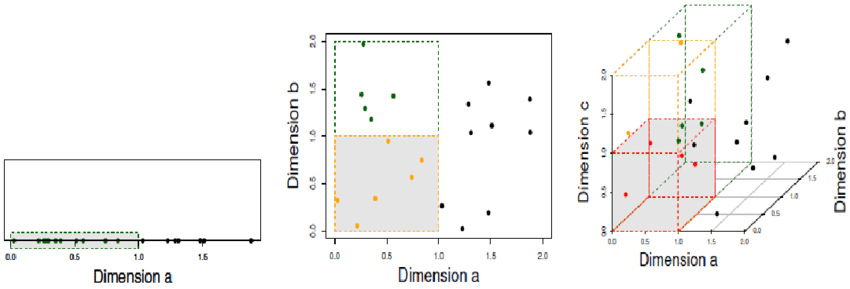

在機器學習領域，當資料集中的特徵（維度）數量極多時，我們常常會遭遇所謂的「**維度災難 (Curse of Dimensionality)**」。在高維空間中，資料點變得極為稀疏，直觀上看似距離很近的點實際上可能彼此相距遙遠，這導致許多依賴距離計算的機器學習演算法（如 K-Nearest Neighbors, 支持向量機）性能急劇下降。此外，過多的特徵不僅會增加模型的訓練時間和記憶體消耗，也可能引入噪音，甚至導致模型過度擬合 (overfitting)。

**降維 (Dimensionality Reduction)** 技術應運而生，它旨在解決這些挑戰。與我們前面學習的「特徵選擇」不同，特徵選擇是從原始特徵中**挑選**一個子集，而降維則是將原始特徵**轉換**或**組合**成一個新的、維度更低的特徵集。這就好比從多個角度拍攝一張照片，然後將所有照片中的重要資訊融合，得到一張更簡潔但資訊量不減的「素描」。

### 為什麼降維至關重要？
1.  **解決維度災難**：減少特徵數量，使資料點在高維空間中不再那麼稀疏，提高模型的穩定性和效能。
2.  **降低計算成本**：特徵越少，模型的訓練和預測速度越快，所需的記憶體也越少。
3.  **去除雜訊與冗餘**：降維可以幫助識別並去除那些不相關或高度冗餘的特徵，有時能提升模型效能。
4.  **資料視覺化**：將高維資料降至 2 或 3 維，使我們能夠直觀地觀察資料的內部結構、群集趨勢和異常點，這對於探索性資料分析 (EDA) 非常有幫助。

---

## 常用降維技術

本節將介紹兩種最常用且最具代表性的降維技術：
1.  **主成分分析 (Principal Component Analysis, PCA)**: 一種線性的降維方法，廣泛應用於資料壓縮、降噪和預處理。
2.  **t-分佈隨機鄰域嵌入 (t-Distributed Stochastic Neighbor Embedding, t-SNE)**: 一種非線性的降維方法，特別擅長於高維資料的視覺化，能很好地保留資料的局部結構。

我們將使用 `scikit-learn` 內建的手寫數字資料集 (`digits`) 來示範這些方法。這個資料集由 8x8 像素的灰度手寫數字圖像組成，共有 64 個特徵（像素值），非常適合用來演示降維的可視化效果。

---

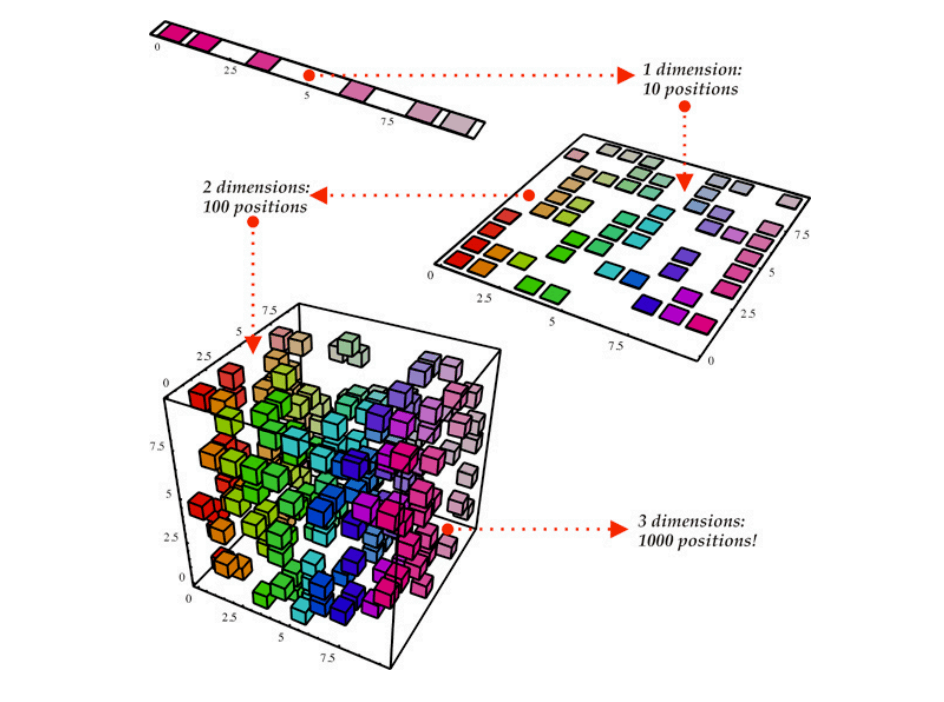

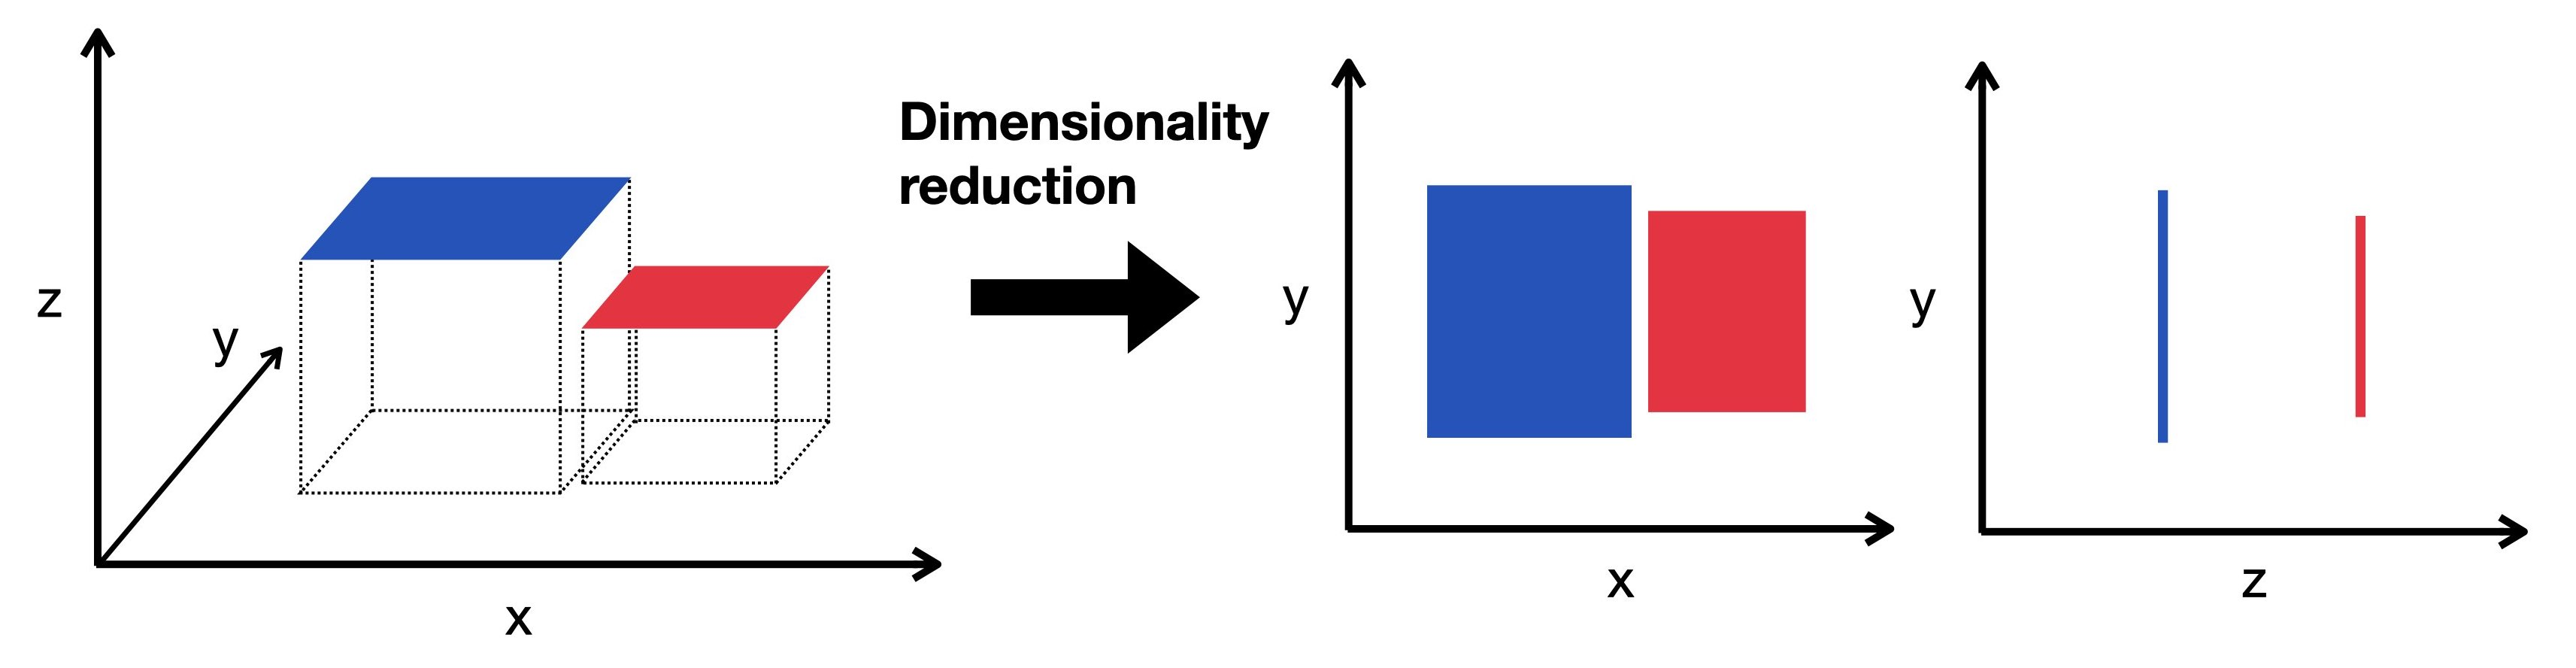

## 1. 載入套件與資料

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 設定繪圖樣式
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')

# 載入手寫數字資料集
digits = load_digits()
X = digits.data # 圖像資料，每個圖像有 64 個像素特徵
y = digits.target # 圖像代表的數字 (0-9)

print("手寫數字資料集載入成功！")
print(f"原始資料集形狀 (樣本數, 特徵數): {X.shape}")
print(f"每個圖像由 {int(np.sqrt(X.shape[1]))}x{int(np.sqrt(X.shape[1]))} 像素組成，共 {X.shape[1]} 個特徵。")

# 顯示前幾筆資料 (通常是數字圖像的像素值)
print("\n原始資料 (前5筆圖像的像素特徵)：")
display(pd.DataFrame(X).head())



Matplotlib and Seaborn styles configured.
手寫數字資料集載入成功！
原始資料集形狀 (樣本數, 特徵數): (1797, 64)
每個圖像由 8x8 像素組成，共 64 個特徵。

原始資料 (前5筆圖像的像素特徵)：


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


## 2. 主成分分析 (Principal Component Analysis, PCA)

**主成分分析 (PCA)** 是一種無監督的線性降維技術，它將資料投影到一個新的正交座標系統上。這個新座標系統的軸線被稱為「主成分 (Principal Components)」，它們是原始特徵的線性組合。PCA 的目標是找到能最大化資料變異性的方向，使得第一主成分捕捉到最大的變異，第二主成分捕捉到次大的變異，依此類推，且所有主成分之間是線性無關（正交）的。

**PCA 的核心思想**：尋找資料中變異最大的方向，並將資料投影到這些方向上，從而降低維度。

### PCA 步驟概覽
1.  **資料標準化**：由於 PCA 對特徵的尺度非常敏感（變異大的特徵會主導主成分的選擇），因此通常在應用 PCA 前需要對資料進行標準化 (Standardization)。
2.  **計算共變異數矩陣**：衡量不同維度之間變異的關係。
3.  **計算特徵值和特徵向量**：特徵向量代表了主成分的方向，特徵值代表了在該方向上的變異大小。
4.  **選擇主成分**：根據特徵值的大小從大到小排序，選擇能解釋大部分資料變異的前 k 個特徵向量作為新的特徵空間。
5.  **投影資料**：將原始資料投影到由選定主成分構成的新空間中。

正在進行資料標準化...
資料標準化完成！
正在執行 PCA...
PCA 完成！


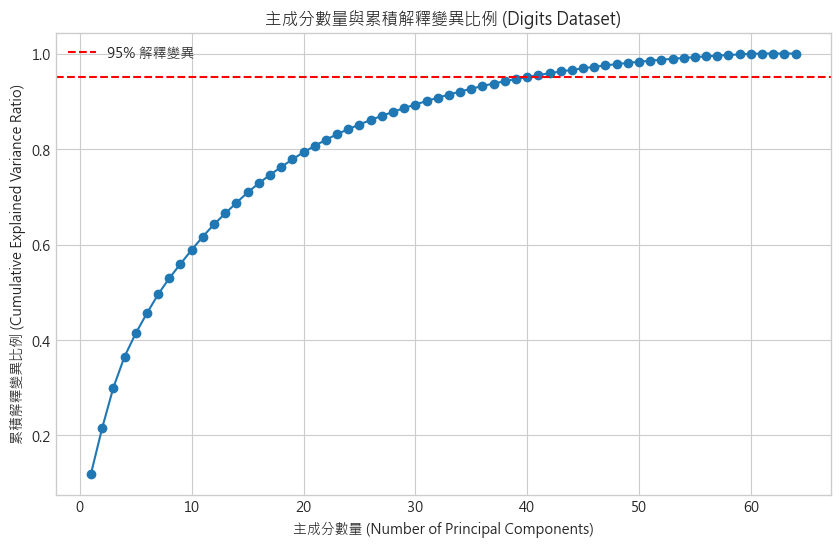

為了能夠解釋至少95%的資料變異，我們需要 40 個主成分。
將資料降維至 2 維後形狀: (1797, 2)


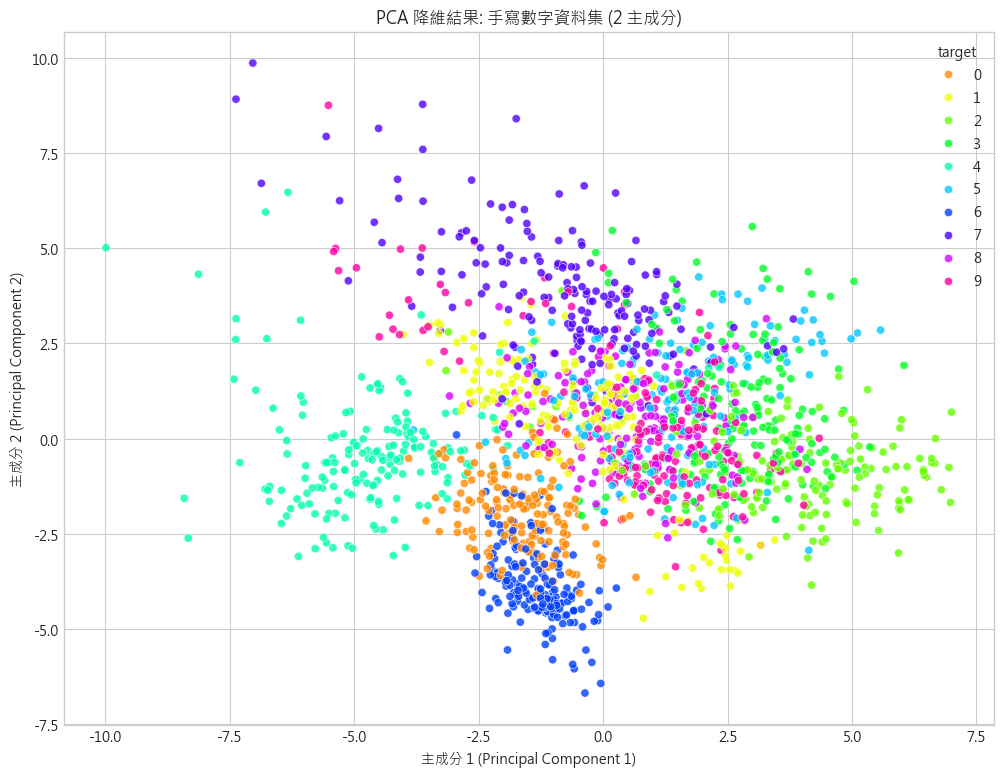

In [8]:
print("正在進行資料標準化...")
# 1. 資料標準化：確保每個特徵的均值為0，標準差為1
X_scaled = StandardScaler().fit_transform(X)
print("資料標準化完成！")

print("正在執行 PCA...")
# 2. 應用PCA：先不指定降維後的維度，以便觀察每個主成分解釋的變異比例
pca = PCA()
pca.fit(X_scaled) # 在標準化後的數據上擬合 PCA 模型

# 計算每個主成分解釋的變異比例的累積和
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

print("PCA 完成！")

# 視覺化解釋變異：了解多少個主成分能夠解釋資料的多少變異
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o')
plt.xlabel("主成分數量 (Number of Principal Components)")
plt.ylabel("累積解釋變異比例 (Cumulative Explained Variance Ratio)")
plt.title("主成分數量與累積解釋變異比例 (Digits Dataset)")
plt.grid(True)
plt.axhline(y=0.95, linestyle='--', color='r', label='95% 解釋變異')
plt.legend()
plt.show()

# 找出能解釋95%變異所需的最少主成分數量
n_components_95 = np.where(explained_variance_ratio_cumulative >= 0.95)[0][0] + 1
print(f"為了能夠解釋至少95%的資料變異，我們需要 {n_components_95} 個主成分。")

# 使用PCA將資料降至2維以進行視覺化，這是最常見的降維應用場景之一
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

print(f"將資料降維至 2 維後形狀: {X_pca.shape}")

# 建立DataFrame方便繪圖，將降維後的數據和原始標籤結合
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['target'] = y

# 繪製 PCA 結果：觀察不同數字類別在 2 維空間中的分佈
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='target',
    palette=sns.color_palette("hsv", 10), # 使用不同的顏色區分數字類別
    data=df_pca,
    legend="full", # 顯示圖例
    alpha=0.8 # 設置點的透明度
)
plt.title("PCA 降維結果: 手寫數字資料集 (2 主成分)")
plt.xlabel("主成分 1 (Principal Component 1)")
plt.ylabel("主成分 2 (Principal Component 2)")
plt.show()



**結果解讀與討論**：

- **解釋變異比例圖**：此圖清晰地展示了隨著主成分數量的增加，模型所能解釋的資料總變異量如何累積。我們可以看到，僅用少數主成分就能解釋資料的大部分變異。例如，僅用約 15 個主成分就能解釋超過 95% 的原始資料變異。
- **2 維 PCA 散佈圖**：在降維到 2 維後，雖然不同數字的類別點有重疊，但我們仍然可以看出某些數字（如 0, 1）傾向於聚集在特定的區域，而其他數字的分佈則更為混雜。這表明 PCA 能夠捕捉到資料中的主要線性結構，但對於複雜的非線性資料，其區分能力可能有限。

## 3. t-SNE (t-Distributed Stochastic Neighbor Embedding)

**t-SNE (t-分佈隨機鄰域嵌入)** 是一種非線性降維演算法，特別擅長於將高維數據點映射到 2 或 3 維空間，同時**盡力保留原始資料中的局部結構**（即在高維空間中相近的點，在低維空間中也盡量相近）。它通過將高維和低維空間中的點間相似性轉換為機率分佈，並試圖最小化這些機率分佈之間的差異（Kullback-Leibler divergence）來實現降維。



### KL散度是什麼？

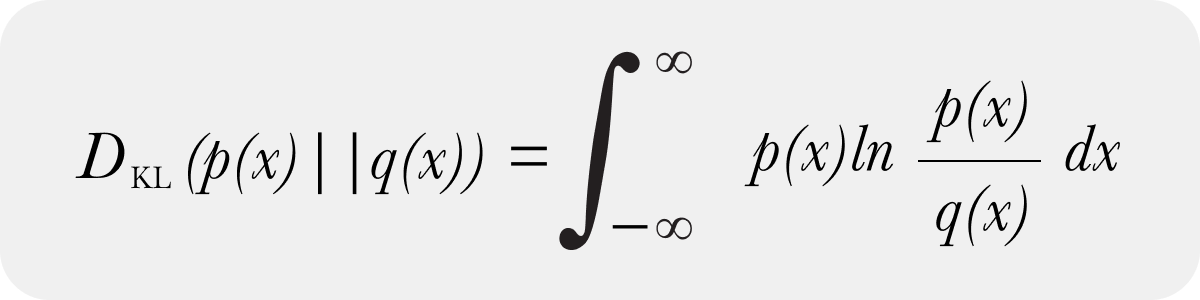



KL散度是一種比較兩個機率分布「有多不一樣」的方法。
你可以把它想像成
**如果你以為世界是A樣子（模型預測的分布），但實際上世界是B樣子（真實分布），那麼你錯得有多離譜？**

KL散度衡量「如果你用Q來描述P，會損失多少資訊」。
KL散度越小，表示Q越接近P。

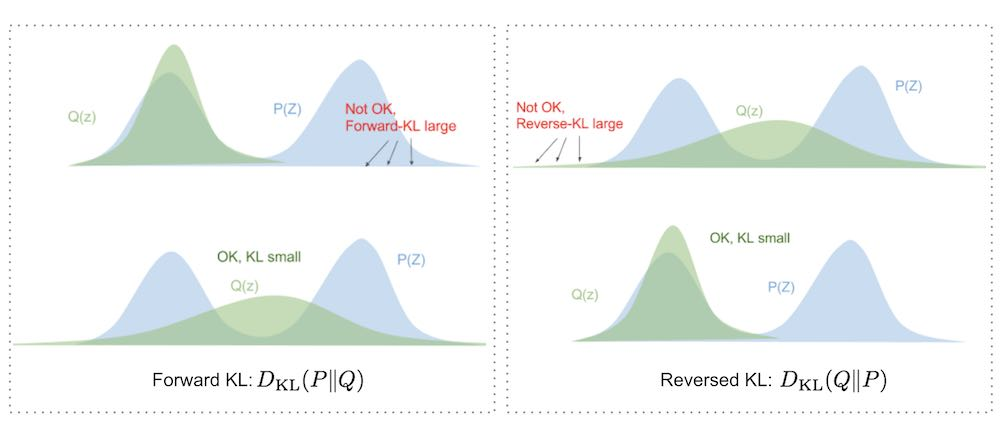

- Forward KL容忍Q「多包一點」，但不能「漏掉」P有的地方。
- Reverse KL會讓Q「縮在」P的主要區域，不敢亂包太多沒必要的地方。

- **Forward KL怕漏掉P的尾巴，Reverse KL怕Q包到P沒的地方。**


**t-SNE 的核心思想**：將高維資料點之間的相似性轉化為機率，並在低維空間中尋找一個新的映射，使得這些機率分佈盡可能地匹配，從而揭示潛在的群集結構。

### t-SNE 的重要參數：
-   `n_components`: 降維後的維度數，通常設置為 2 或 3，以便於視覺化。
-   `perplexity`: **困惑度**。這是一個非常關鍵的參數，可以理解為每個資料點的「近鄰數量」。它的值通常設置在 5 到 50 之間。較小的 `perplexity` 值強調局部結構，較大的值則強調全局結構。調整此參數對最終的視覺化結果有顯著影響。
-   `n_iter`: 優化的最大迭代次數。足夠的迭代次數對於 t-SNE 收斂至穩定結果很重要。
-   `learning_rate`: 學習率，影響優化過程的速度。

**應用注意事項**：
- **計算成本高**：t-SNE 的計算量非常大，尤其是在資料集包含大量樣本或高維特徵時。通常建議先使用 PCA 等線性降維方法對資料進行初步降維（例如降到 50 維），再應用 t-SNE，以加速計算並減少噪音。
- **結果的局限性**：t-SNE 的結果中，群集的大小和群集之間的距離不一定具有實際意義，它主要用於揭示資料的群集結構和視覺化，不適合直接用於後續的模型訓練作為特徵。
- **隨機性**：由於其優化過程包含隨機初始化，每次運行可能會得到略有不同的結果，除非固定 `random_state`。

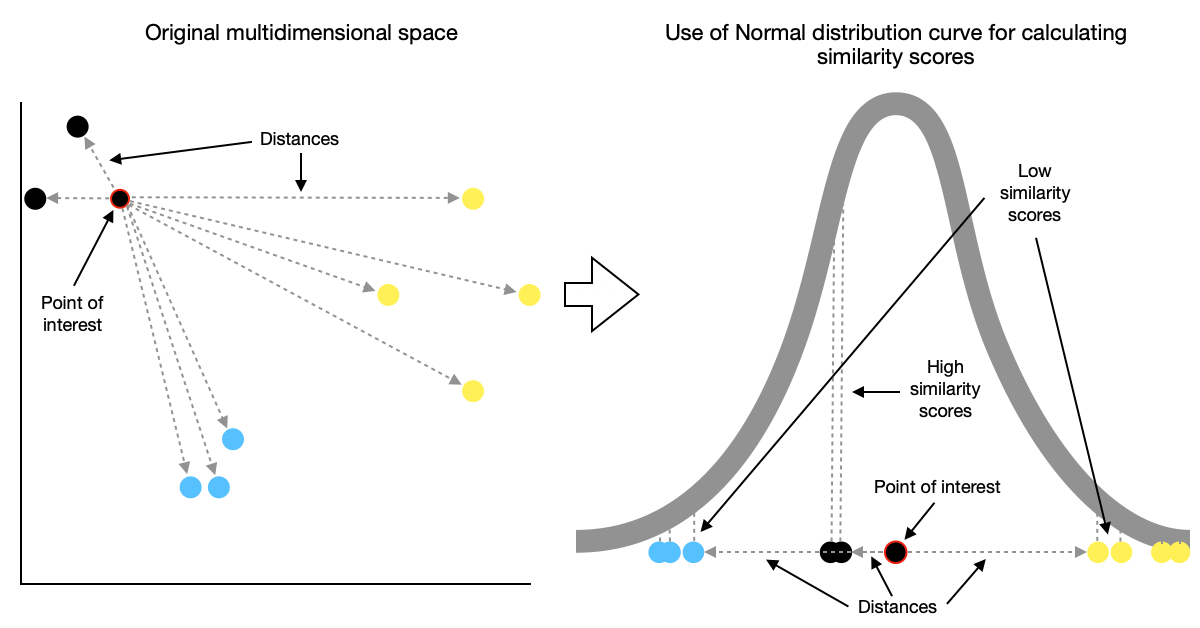

正在執行 t-SNE 降維 (這可能需要一些時間)...
t-SNE 降維完成！
降維後資料形狀: (1797, 2)


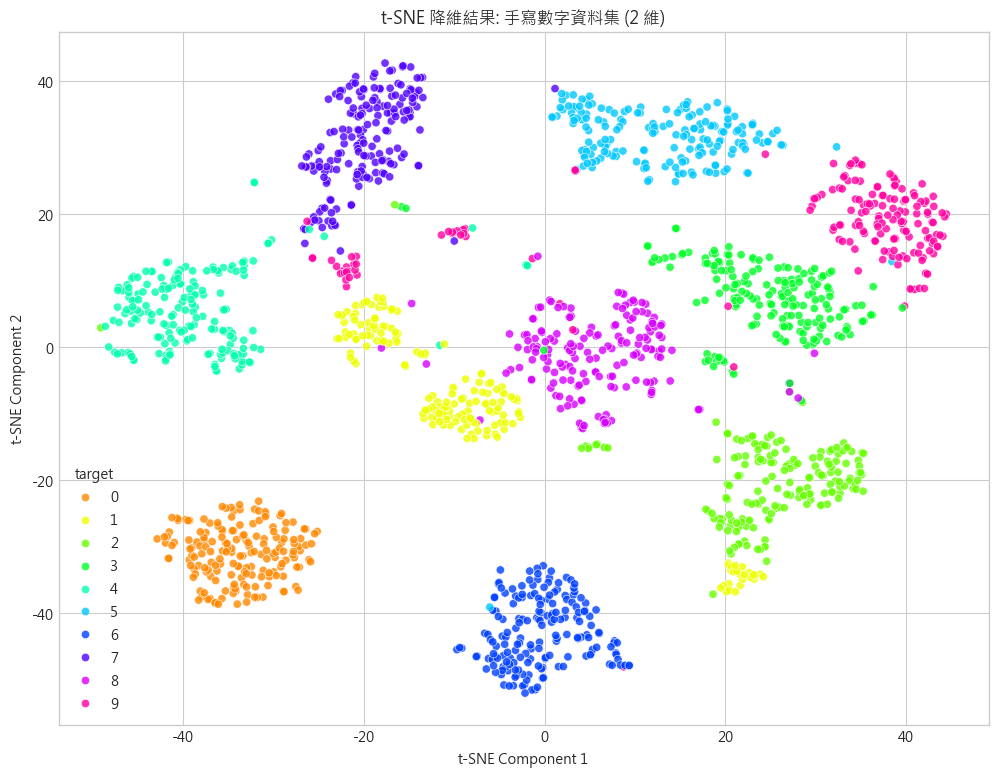

In [9]:
print("正在執行 t-SNE 降維 (這可能需要一些時間)...")
# 應用 t-SNE。這裡我們直接在標準化後的資料上運行，因為資料集規模不大。
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

print("t-SNE 降維完成！")
print(f"降維後資料形狀: {X_tsne.shape}")

# 建立DataFrame方便繪圖，將降維後的數據和原始標籤結合
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['target'] = y

# 繪製 t-SNE 結果：觀察不同數字類別在 2 維空間中的分佈
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='target',
    palette=sns.color_palette("hsv", 10),
    data=df_tsne,
    legend="full",
    alpha=0.8
)
plt.title("t-SNE 降維結果: 手寫數字資料集 (2 維)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()



**結果解讀與討論**：

從 t-SNE 的視覺化結果可以明顯看出，它成功地將手寫數字資料中的不同類別（0-9）分成了非常清晰且區分度高的群集。與 PCA 相比，t-SNE 在保留資料的局部結構方面表現優異，這使得它成為高維資料探索性視覺化的強大工具。即使資料在原始 64 維空間中非常複雜，t-SNE 也能揭示出潛在的低維結構和群集模式。

## 4. PCA vs. t-SNE 總結與比較

PCA 和 t-SNE 都是強大的降維工具，但它們的工作原理、優點、缺點和適用場景截然不同。選擇哪種方法取決於你的具體目標：資料壓縮、模型訓練、還是資料視覺化。

| 特性/方法 | **主成分分析 (PCA)** | **t-SNE** |
| :--- | :--- | :--- |
| **原理** | 線性變換，尋找資料變異最大的正交方向（主成分）。 | 非線性變換，將高維相似性轉化為機率，並在低維空間中保留局部結構。 |
| **目的** | 資料壓縮、降噪、預處理，保留全局變異。 | 主要用於高維資料的視覺化，揭示群集結構。 |
| **轉換結果** | 原始特徵的線性組合，結果是確定性的（若 `random_state` 固定）。 | 非線性轉換，結果具有一定隨機性（即使 `random_state` 固定，不同運行可能佈局不同）。 |
| **解釋性** | 主成分是可解釋的（是原始特徵的線性組合）。 | 新的維度通常不可解釋，群集大小和距離不代表實際意義。 |
| **計算成本** | 相對較低，適合處理大規模資料集。 | 計算成本高，尤其對大規模資料集。 |
| **對異常值敏感性** | 敏感，因為基於均值和共變異數。 | 相對不敏感於少數異常值，但極端值可能影響佈局。 |
| **適用場景** | 作為模型訓練前的預處理步驟，資料壓縮，減少共線性。 | 探索性資料分析 (EDA)，視覺化高維資料的群集結構。

### 使用時機的策略

-   **如果你的主要目標是將高維資料降維，並將降維後的結果用於後續的機器學習模型訓練**：
    **PCA** 通常是首選。它保留了資料的全局變異資訊，並且轉換是線性的，這使其結果具有一定的可解釋性。
-   **如果你的主要目標是探索性資料分析，希望將高維資料視覺化，以理解其內在的群集結構或分佈模式**：
    **t-SNE** 是更強大的工具。它能揭示複雜的非線性結構，使不同類別的資料點在低維空間中形成清晰的群集。
-   **一個常見且高效的工作流程**：對於非常高維的資料集，可以先使用 PCA 將資料降到一個中間維度（例如，降到 50 到 100 維），然後再將這個中等維度的資料輸入給 t-SNE，降至 2 或 3 維進行視覺化。這樣做可以利用 PCA 的計算效率來進行初步降維和降噪，同時利用 t-SNE 的強大視覺化能力來揭示資料的細微結構。

透過這些降維技術，我們能夠有效地管理高維資料的複雜性，使其更易於理解、處理，並最終提升機器學習模型的性能。